In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import pandas as pd
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm


In [111]:
train_imgs_path = '../data/fungi-clef-2025/images/FungiTastic-FewShot/train/300p/'
val_imgs_path = '../data/fungi-clef-2025/images/FungiTastic-FewShot/val/300p/'
# test_imgs_path = '../data/fungi-clef-2025/images/FungiTastic-FewShot/test/300p/'

train_metadata_path = '../data/fungi-clef-2025/metadata/FungiTastic-FewShot/FungiTastic-FewShot-Train.csv'
val_metadata_path = '../data/fungi-clef-2025/metadata/FungiTastic-FewShot/FungiTastic-FewShot-Val.csv'
# test_metadata_path = '../data/fungi-clef-2025/metadata/FungiTastic-FewShot/FungiTastic-FewShot-Test.csv'

df_train = pd.read_csv(train_metadata_path)
df_train['filepath'] = train_imgs_path + df_train['filename']

df_val = pd.read_csv(val_metadata_path)
df_val['filepath'] = val_imgs_path + df_val['filename']

In [112]:
# Gets rid of low frequency classes (less than 10 observations)
valid_classes = df_train['class'].value_counts()
valid_classes = valid_classes[valid_classes >= 10].index

# Filter to keep only those classes
df_train = df_train[df_train['class'].isin(valid_classes)]
df_val = df_val[df_val['class'].isin(valid_classes)]

In [113]:
#preprocessing

# #1 rename current validation set to new test set
df_test = df_val.copy()

# # #2 Keep only classes with at least 2 samples in order to stratify
# class_counts = df_train['class'].value_counts()
# valid_classes = class_counts[class_counts >= 2].index
# df_train_filtered = df_train[df_train['class'].isin(valid_classes)]

# #3 Split while stratifying by class
df_train, df_val = train_test_split(
    df_train,
    test_size=0.2,
    stratify=df_train['class'],  # preserves class distribution
    random_state=42
)

# #4 remove observations with missing features
df_train = df_train.dropna()
df_val = df_val.dropna()
df_test = df_test.dropna()

# #5 Ensure all classes in df_val are also in df_train
train_classes = set(df_train['class'])
val_classes = set(df_val['class'])
print(train_classes)
print(val_classes)
# df_val = df_val[df_val['class'].isin(train_classes)]  # filter out unseen classes


{'Pezizomycetes', 'Exobasidiomycetes', 'Agaricomycetes', 'Eurotiomycetes', 'Coniocybomycetes', 'Peronosporea', 'Orbiliomycetes', 'Entomophthoromycetes', 'Tremellomycetes', 'Mucoromycetes', 'Leotiomycetes', 'Microbotryomycetes', 'Laboulbeniomycetes', 'Myxomycetes', 'Candelariomycetes', 'Lecanoromycetes', 'Sordariomycetes', 'Geoglossomycetes', 'Arthoniomycetes', 'Pucciniomycetes', 'Taphrinomycetes', 'Ustilaginomycetes', 'Dacrymycetes', 'Dothideomycetes'}
{'Pezizomycetes', 'Exobasidiomycetes', 'Agaricomycetes', 'Eurotiomycetes', 'Coniocybomycetes', 'Peronosporea', 'Orbiliomycetes', 'Entomophthoromycetes', 'Tremellomycetes', 'Mucoromycetes', 'Leotiomycetes', 'Microbotryomycetes', 'Laboulbeniomycetes', 'Myxomycetes', 'Candelariomycetes', 'Lecanoromycetes', 'Sordariomycetes', 'Geoglossomycetes', 'Arthoniomycetes', 'Pucciniomycetes', 'Taphrinomycetes', 'Ustilaginomycetes', 'Dacrymycetes', 'Dothideomycetes'}


In [114]:
print(len(df_train))
print(len(df_val))
print(len(df_test))

5571
1406
2180


In [115]:
# enumerate class labels
le = LabelEncoder()
# Only fit on training labels
le.fit(df_train['class'])

# We know the new test (old val) only contains classes that were seen in the old train so model won't be surprised in 
df_train['label'] = le.transform(df_train['class'])
df_val['label'] = le.transform(df_val['class'])
df_test['label'] = le.transform(df_test['class'])

In [116]:
train_class_counts = df_train['class'].value_counts()
train_class_counts

class
Agaricomycetes          2202
Leotiomycetes            794
Sordariomycetes          557
Lecanoromycetes          480
Dothideomycetes          363
Pezizomycetes            325
Myxomycetes              286
Pucciniomycetes          176
Eurotiomycetes            62
Ustilaginomycetes         41
Tremellomycetes           37
Exobasidiomycetes         36
Peronosporea              33
Orbiliomycetes            26
Dacrymycetes              24
Mucoromycetes             21
Microbotryomycetes        20
Arthoniomycetes           17
Taphrinomycetes           15
Entomophthoromycetes      13
Coniocybomycetes          13
Geoglossomycetes          11
Candelariomycetes         11
Laboulbeniomycetes         8
Name: count, dtype: int64

In [ ]:
# Augmenting class images with low frequency

# Need a df that just contains the images of the rare classes 
threshold = int(train_class_counts.mean())
# minority_classes = train_class_counts[train_class_counts < threshold].index

# # Filter to rows belonging to minority classes
# minority_df = df_train[df_train['class'].isin(minority_classes)]
# minority_df['class'].value_counts()#.to_csv('minority_df.csv')

In [122]:
df_train['class'].value_counts()['Eurotiomycetes']

np.int64(62)

In [127]:
#Create a mapping of each minority class to all of its filepaths
class_to_paths = {}
for _, row in df_train.iterrows():
    curr_class = row['class']
    #Checks whether class is underrepresented
    if train_class_counts[curr_class] < threshold:
        # If not already in the dictionary, initialize empty list
        if curr_class not in class_to_paths:
            class_to_paths[curr_class] = []
        # add filepath of current image to the list for this class
        class_to_paths[curr_class].append(row['filepath'])

In [132]:
import random

def augment_image(image):
    # Random flip, brightness, contrast, saturation, hue, rotation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    image = tf.image.random_hue(image, max_delta=0.02)

    # Random rotation (0=0degrees, 1=90, 2=180, 3=270)
    k = random.randint(0, 3)
    image = tf.image.rot90(image, k=k)
    return image

In [ ]:
# Augment images

augmented_metadata = []

#loop through each minority class and all the original image filepaths for the current class
for curr_class, filepaths in tqdm(class_to_paths.items()):
    #count how many images we have and how many more we need to create
    current_count = len(filepaths)
    num_needed = threshold - current_count

    # keep going until there's enough images
    # even if a class has only 20 images and we need 200 more, we keep applying different augmentations to those same original 20 images
    i = 0 #number of images we've creates so far
    while i < num_needed:
        # Cycle through existing images if needed
        for path in filepaths:
            if i >= num_needed:
                break
            img = load_img(path)
            img_tensor = tf.convert_to_tensor(img_to_array(img))
            # flip, rotate, birghtness, contrast, saturation, hue
            img_tensor = augment_image(img_tensor)
            # good to clip values when using birghtness/contrast/hue augmentation, keeps RGB vals between 0 and 255
            img_tensor = tf.clip_by_value(img_tensor, 0, 255)

            #save aug image
            new_filename = f"{curr_class}_aug_{i}.jpg"
            save_path = os.path.join("../data/augmented_images", new_filename)
            #use np.uint8 for raw images or any strictly‑non‑negative quantity that fits in 0‑255 & where memory bandwidth matters
            save_img(save_path, img_tensor.numpy().astype(np.uint8))

            # Fetch metadata from original DataFrame
            # findthe row in df_train that corresponds to the augmented image
            meta_row = df_train[df_train['filepath'] == path].iloc[0].copy()
            #update path accordingly
            meta_row['filepath'] = save_path
            meta_row['filename'] = new_filename
            augmented_metadata.append(meta_row)
            
            i += 1

100%|██████████| 17/17 [00:11<00:00,  1.44it/s]


In [139]:
df_augmented = pd.DataFrame(augmented_metadata)
df_augmented['is_augmented'] = True

# Add to original dataframe
df_train['is_augmented'] = False
df_train_combined = pd.concat([df_train, df_augmented], ignore_index=True)

In [142]:
df_train_combined['class'].value_counts()

class
Agaricomycetes          2202
Leotiomycetes            794
Sordariomycetes          557
Lecanoromycetes          480
Dothideomycetes          363
Pezizomycetes            325
Myxomycetes              286
Arthoniomycetes          232
Laboulbeniomycetes       232
Tremellomycetes          232
Candelariomycetes        232
Coniocybomycetes         232
Entomophthoromycetes     232
Geoglossomycetes         232
Exobasidiomycetes        232
Ustilaginomycetes        232
Dacrymycetes             232
Pucciniomycetes          232
Orbiliomycetes           232
Peronosporea             232
Mucoromycetes            232
Microbotryomycetes       232
Eurotiomycetes           232
Taphrinomycetes          232
Name: count, dtype: int64

In [ ]:
# preprocess train image data

X_train = []
y_train = []

for i, row in df_train.iterrows():
    # Load image using designated filepath
    img = load_img(row['filepath'])
    img_array = img_to_array(img)

    # Need to convert to tensor to use resize_with_pad
    img_tensor = tf.convert_to_tensor(img_array)
    # Preserves aspect ratio, pads with black bars to account for resizing
    # prevents the image from getting cropped out
    img_tensor = tf.image.resize_with_pad(img_tensor, target_height=300, target_width=300)

    img_tensor = img_tensor / 255.0  # Normalize

    X_train.append(img_tensor)  # DON'T convert back to NumPy (keep as tensor)
    y_train.append(row['label'])

X_train = tf.stack(X_train) # now shape is (len(df_train), 300, 300, 3)
y_train = tf.convert_to_tensor(y_train) #convert outcome to tensor

In [50]:
#preprocess val image data

X_val = []
y_val = []

for i, row in df_val.iterrows():
    # Load image using designated filepath
    img = load_img(row['filepath'])
    img_array = img_to_array(img)

    # Need to convert to tensor in order to use resize_with_pad
    img_tensor = tf.convert_to_tensor(img_array)
    # Preserves aspect ratio, pads with black bars to account for resizing
    # prevents the image from getting cropped out
    img_tensor = tf.image.resize_with_pad(img_tensor, target_height=300, target_width=300)
    # ADD EXTRA AUGMENTATION STEPS HERE
    # print(type(img_tensor))
    img_tensor = img_tensor / 255.0  # Normalize

    X_val.append(img_tensor)
    y_val.append(row['label'])

X_val = tf.stack(X_val)
y_val = tf.convert_to_tensor(y_val)

In [51]:
#preprocess test image data

X_test = []
y_test = []

for i, row in df_test.iterrows():
    # Load image using designated filepath
    img = load_img(row['filepath'])
    img_array = img_to_array(img)

    # Need to convert to tensor in order to use resize_with_pad
    img_tensor = tf.convert_to_tensor(img_array)
    # Preserves aspect ratio, pads with black bars to account for resizing
    # prevents the image from getting cropped out
    img_tensor = tf.image.resize_with_pad(img_tensor, target_height=300, target_width=300)
    # ADD EXTRA AUGMENTATION STEPS HERE
    # print(type(img_tensor))
    img_tensor = img_tensor / 255.0  # Normalize

    X_test.append(img_tensor)
    y_test.append(row['label'])

X_test = tf.stack(X_test)
y_test = tf.convert_to_tensor(y_test)

In [29]:
# define an instance of the early_stopping class
early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='accuracy',
verbose=1,
patience=3,
mode='max',
restore_best_weights=True)

In [ ]:
# naive baseline for training set
df_train['class'].value_counts().iloc[0]/len(df_train)

In [34]:
num_classes = len(set(y_train.numpy()))
num_classes

30

Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - accuracy: 0.3538 - loss: 2.6377 - val_accuracy: 0.4055 - val_loss: 2.1636
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 365s 4s/step - accuracy: 0.3956 - loss: 2.1878 - val_accuracy: 0.4055 - val_loss: 2.1079
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.4064 - loss: 2.1510 - val_accuracy: 0.4055 - val_loss: 2.0977
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 336s 3s/step - accuracy: 0.4084 - loss: 2.1407 - val_accuracy: 0.4055 - val_loss: 2.0408
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 1608s 17s/step - accuracy: 0.4133 - loss: 2.0900 - val_accuracy: 0.4055 - val_loss: 2.0390
Restoring model weights from the end of the best epoch: 5.


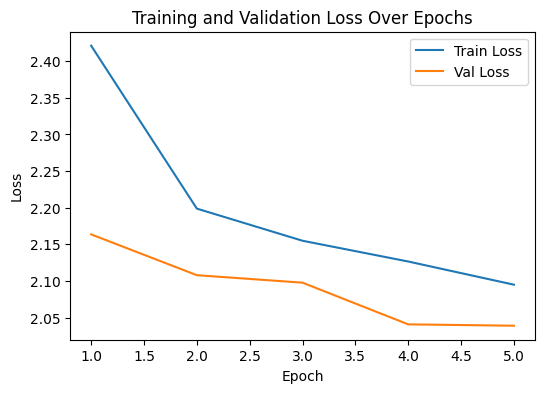

In [ ]:
num_classes = len(set(y_train.numpy()))

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(300, 300, 3)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.4),

    # tf.keras.layers.Flatten(),
    tf.keras.layers.GlobalAveragePooling2D(), #generalizes better and reduces overfitting risk
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')  # softmax for multi-class
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=64,
    callbacks=[early_stopping]
)

# plot loss curves
### YOUR CODE HERE ###
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(6, 4))

epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [54]:
len(df_test[df_test['class'] == 'Agaricomycetes']) / len(df_test)

0.15045871559633028

In [52]:
loss, accuracy = model.evaluate(X_test, y_test, batch_size=64)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


35/35 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.1478 - loss: 2.4386
Test Loss: 2.4416
Test Accuracy: 0.1505
